#### Imports

In [455]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import shutil

#### LSTM parameters

- n_signals: signals fed into model for each event (i.e. for input signals: [$I_{a}$, $I_{b}$, $I_{c}$] -> n_signals = 3).
- N: window size. For 3840Hz sampling frequency and a 0.016ms window (containing one cycle of a 60Hz wave), N = 64.
$$ N = fs/f_{fundamental}$$
- target_size
    - target_size = 1:
        - Binary Classification: One output treated as probability of belonging to one class or the other (E.g. No-Fault: 0 /Fault: 1)
    - target_size > 1:
        - Multiclass: Multiple exclusive classes. Class with higher score represents predicted class. The sum of scores (using softmax) always sums 1. (E.g. [No-fault, Fault, Caps], a output of values [0.07, 0.91, 0.2] represents a Fault class prediction)
        - Multilabel: Multiple classes that are not mutually exclusive.

In [456]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
tagset_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#### Model Creation

(Hablar un poco de la arquitectura del modelo)

In [499]:
# Model Creation


class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")


Model structure: FaultDetector(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)



#### Dataset Class 

In [500]:
from utils.signalload import CSV_pandas_path
from utils.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(self, dataset_dir, max_window_idx=193, window_length=64, step=1, test=False):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = 1

    def __getitem__(self, index):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signal, t, _ = CSV_pandas_path(csv_full_path).load_data("I: X0023A-R1A")
        signal_windows, t_windows = list(
            map(moving_window, [signal, t], repeat(window_length), repeat(step))
        )
        

        # select window
        
        signal_window = signal_windows[window_idx]
        signal_window = np.expand_dims(signal_window, axis=1)
        t_window = t_windows[window_idx]

        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        if self.test == True:
            return signal_window, t_window, label, csv_name, index, window_idx
        signal_window = torch.from_numpy(signal_window).float()
        label = torch.from_numpy(label).float()
        return signal_window, label
    def __len__(self):
        return self.csv_amount * self.max_window_idx

In [504]:
# Creating Dataset
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1_test/"
max_window_idx = 130
dataset = Form1Dataset(dataset_dir, max_window_idx=max_window_idx)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)




In [505]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [506]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------------------------
loss: 0.670942 [    0/ 2340]
loss: 0.475121 [  640/ 2340]
loss: 0.388677 [ 1280/ 2340]
loss: 0.247591 [ 1920/ 2340]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.211738 



In [518]:
# Save the Model
torch.save(model.state_dict(), './models/Formulacion_1.pth')
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights.pth'))

In [508]:
dataset = Form1Dataset(dataset_dir, max_window_idx=max_window_idx)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
dataiter = iter(train_dataloader)
signal, labels = next(dataiter)
# signal = signal.float()
# labels = labels.float()
x = model(signal.to(device))
print(labels)
print(x)
print(torch.round(x))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])
tensor([[0.0580],
        [0.0567],
        [0.0589],
        [0.2400],
        [0.1209],
        [0.1247],
        [0.6478],
        [0.1640]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)


In [ ]:
# Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights.pth')
model.load_state_dict(torch.load('./models/LSTMHarmonic_weights.pth'))

tensor([[0., 1., 1., 0., 0., 1., 0., 0., 1.]])
torch.Size([16, 64, 1])
tensor([[0.0535, 0.9496, 0.6285, 0.1074, 0.2057, 0.9543, 0.1281, 0.0543, 0.7718]],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[0., 1., 1., 0., 0., 1., 0., 0., 1.]], grad_fn=<ReshapeAliasBackward0>)


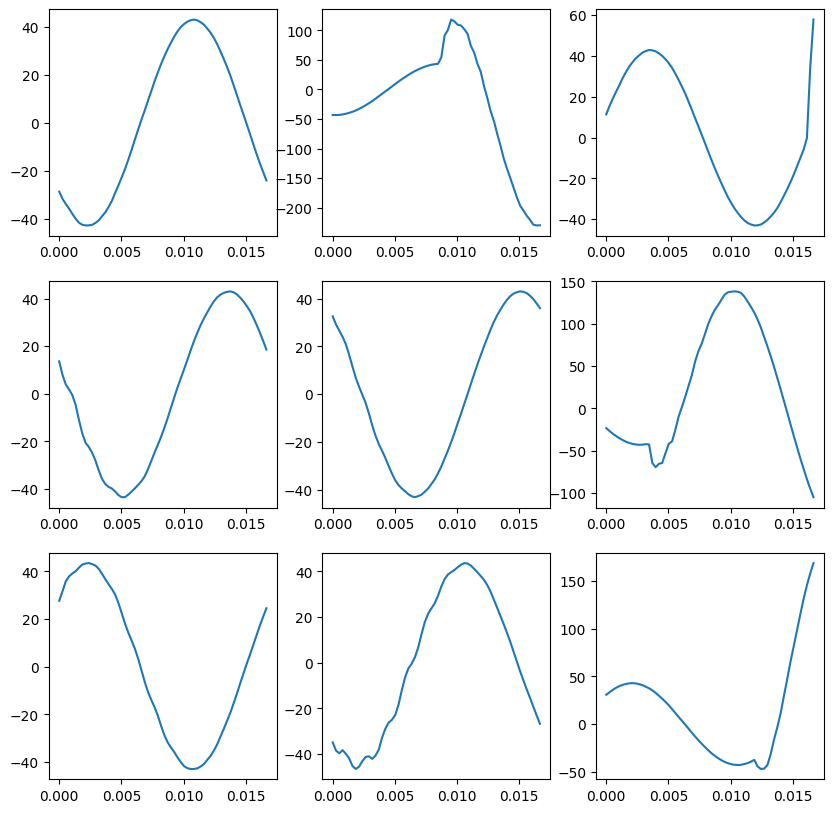

In [517]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(torch.reshape(labels[1:10], (1, -1)))
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.reshape(x, (1, -1)))
print(torch.reshape(torch.round(x), (1, -1)))
